In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

%matplotlib inline
%config InlineBackend.feature_format = 'retina'

### Loading in the DataFrame that I made which includes data about all the books. The text of the books has been removed now that I have data about the words, syllables, reading levels, and subjects extracted. I also make the subjects easier to parse through and load up the tfidf vectorized books dataframe and the count vectorized books dataframe.

In [3]:
meta_stats = pd.read_csv('meta_stats_all_notext', encoding = 'utf8', index_col = 'Unnamed: 0')

In [4]:
meta_stats['subjects2'] = meta_stats['subjects2'].map(lambda x: x.replace('[', '').replace(']','').split(','))

def clean_sub2(sublist):
    subs = []
    for s in sublist:
        subs.append(string.strip(s))
    return subs

meta_stats['subjects2'] = meta_stats['subjects2'].map(clean_sub2)

In [5]:
def unique_words(subjects):
    s = []
    for x in subjects:
        s.extend(x.split(' '))
    return np.unique(s)

meta_stats['subjects3'] = meta_stats['subjects2'].map(unique_words)

In [6]:
tvec_all = pd.read_csv('tvec_all', encoding = 'utf8', index_col = 'Unnamed: 0')

In [7]:
cvec_all = pd.read_csv('cvec_all', encoding = 'utf8', index_col = 'Unnamed: 0')

### The user selects a book and the dataframe is narrowed down to only include the books within a range of appropriate reading levels of that book.

In [9]:
chosen_title = "Peter Pan"

In [10]:
try:
    chosen_book = meta_stats[meta_stats['title'] == chosen_title]
    chosen_id = chosen_book['book_id'].values[0]
    print (chosen_id)
    
except:
    print ("This book is not in the dataset. Choose another book.")

16


#### Here is the range of reading levels that will be allowed:

In [11]:
flesch_k_max = chosen_book['flesch_kincaid_grade'].values[0] + 0.25
flesch_k_min = chosen_book['flesch_kincaid_grade'].values[0] - 1.00
flesch_k_min, flesch_k_max

(6.1631893250800003, 7.4131893250800003)

In [12]:
flesch_k_subset = meta_stats[meta_stats['flesch_kincaid_grade'].between(flesch_k_min, flesch_k_max)].reset_index(drop = True)
flesch_k_subset.shape

(2930, 27)

In [13]:
flesch_k_subset.head(2)

,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,sentence_count,syllable_count,avg_sentence_length,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3
0,15,Moby Dick,MobyDick,"Melville, Herman",1819.0,1891.0,707,"{Ship captains -- Fiction, Whaling ships -- Fi...","[adventure stories, ahab, captain fictitious c...",{PS},...,154,2428,9.889610,1.594222,0.0,0.000000,61.925870,7.078767,{u'text/html': u'http://www.gutenberg.org/eboo...,"[adventure, ahab, captain, captains, character..."
1,16,Peter Pan,PeterPan,"Barrie, J. M. (James Matthew)",1860.0,1937.0,4778,"{Peter Pan (Fictitious character) -- Fiction, ...","[fairies, fantasy, fiction, juvenile fiction, ...","{PZ, PR}",...,3054,67117,15.532744,1.414866,1467.0,0.480354,71.371599,7.163189,{u'text/plain; charset=utf-8': u'http://www.gu...,"[character, fairies, fantasy, fiction, fictiti..."


In [14]:
subset_bids = flesch_k_subset[['book_id']]
subset_bids.shape

(2930, 1)

## Creating a column to recommend books based upon TFIDF

### Loading in the tfidf vectorized books to use for one metric of recommendation.

In [15]:
tvec_all.head(5)

,00,000,10,11,12,12mo,13,14,15,16,...,youa,young,younger,youngest,youngster,youth,youthful,youths,zeal,zip
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.003734,0.004122,0.004122,0.0,0.004321,0.008664,0.004067,0.004321,...,0.0,0.0,0.001161,0.001695,0.0,0.002144,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.012668,0.015863,0.0,0.008360,0.000000,0.0,0.005754,0.0
3,0.0,0.0,0.001540,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.005742,0.002796,0.0,0.008841,0.001341,0.0,0.000000,0.0
4,0.0,0.0,0.005085,0.005614,0.005614,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.006321,0.013852,0.0,0.011680,0.000000,0.0,0.000000,0.0


In [16]:
tvec_subset = subset_bids.merge(tvec_all, how = 'inner', on = 'book_id').reset_index(drop = True)

### I'm using cosine distance to determine how different the books are from each other.

In [17]:
book_ids = tvec_subset.book_id
tvec_subset = tvec_subset.drop('book_id', axis = 1)

t_subset_distances = cosine_distances(tvec_subset)
t_subset_distances_df = pd.DataFrame(t_subset_distances, columns=book_ids)
t_subset_distances_df['book_id'] = book_ids

t_subset_distances_df.head()

book_id,15,16,24,44,47,51,73,95,111,113,...,52702,52704,52788,52909,52964,53166,53320,53394,53704,book_id
0,0.000000,0.969081,0.967276,0.954052,0.987929,0.988819,0.974099,0.976526,0.964068,0.984628,...,0.976249,0.963928,0.946692,0.980878,0.989382,0.911926,0.991825,0.939567,0.961188,15
1,0.969081,0.000000,0.892806,0.830438,0.936222,0.949365,0.942659,0.780589,0.913645,0.944498,...,0.926917,0.940688,0.943436,0.959708,0.968593,0.910546,0.970041,0.941604,0.971819,16
2,0.967276,0.892806,0.000000,0.632616,0.879938,0.897028,0.864185,0.891896,0.799526,0.886249,...,0.891607,0.890919,0.888292,0.929482,0.932299,0.920757,0.939116,0.890174,0.932117,24
3,0.954052,0.830438,0.632616,0.000000,0.792673,0.834362,0.827376,0.849368,0.715684,0.791714,...,0.707072,0.762762,0.859778,0.882718,0.867006,0.861252,0.921806,0.858978,0.926615,44
4,0.987929,0.936222,0.879938,0.792673,0.000000,0.024609,0.941554,0.947862,0.902240,0.907432,...,0.896188,0.935309,0.953450,0.961494,0.939620,0.925159,0.969634,0.957773,0.978592,47


In [18]:
t_chosen_distances = t_subset_distances_df[[chosen_id, 'book_id']]
flesch_k_subset = flesch_k_subset.merge(t_chosen_distances, how = 'inner', on = 'book_id')
flesch_k_subset.rename(columns = {chosen_id : 'tfidf_distances'}, inplace = True)

In [19]:
flesch_k_subset.sort_values('tfidf_distances').head(5)

,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,syllable_count,avg_sentence_length,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3,tfidf_distances
1,16,Peter Pan,PeterPan,"Barrie, J. M. (James Matthew)",1860.0,1937.0,4778,"{Peter Pan (Fictitious character) -- Fiction, ...","[fairies, fantasy, fiction, juvenile fiction, ...","{PZ, PR}",...,67117,15.532744,1.414866,1467.0,0.480354,71.371599,7.163189,{u'text/plain; charset=utf-8': u'http://www.gu...,"[character, fairies, fantasy, fiction, fictiti...",0.000000
1598,26654,Peter and Wendy,PeterandWendy,"Barrie, J. M. (James Matthew)",1860.0,1937.0,673,"{Fantasy, Peter Pan (Fictitious character) -- ...","[fairies, fantasy, fiction, juvenile fiction, ...","{PR, PZ}",...,66921,15.531670,1.414073,18.0,0.005907,71.439787,7.153412,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[character, fairies, fantasy, fiction, fictiti...",0.043960
814,14532,The Honorable Peter Stirling and What People T...,TheHonorablePeterStirlingandWhatPeopleThoughto...,"Ford, Paul Leicester",1865.0,1902.0,5,"{Political fiction, New York (N.Y.) -- Fiction...","[fiction, labor movement, love stories, new yo...",{PS},...,223589,13.349320,1.468575,5516.5,0.483691,69.044036,6.945414,{u'application/rdf+xml': u'http://www.gutenber...,"[fiction, houses, labor, love, movement, new, ...",0.222722
218,3074,The Burgess Bird Book for Children,TheBurgessBirdBookforChildren,"Burgess, Thornton W. (Thornton Waldo)",1874.0,1965.0,217,{Birds -- Juvenile literature},"[birds, juvenile literature]",{QL},...,104960,14.092334,1.406348,1624.5,0.306741,73.554207,6.500921,{u'text/plain; charset=utf-8': u'http://www.gu...,"[birds, juvenile, literature]",0.224676
2795,44150,The Jack-Knife Man,TheJackKnifeMan,"Butler, Ellis Parker",1869.0,1937.0,11,"{Widows -- Fiction, River boats -- Fiction, Fa...","[fathers and sons, fiction, orphans, river boa...",{PS},...,68889,15.594901,1.390433,1307.0,0.411394,73.375549,6.899120,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[and, boats, customs, fathers, fiction, life, ...",0.243898


## Recommending by Count Vectorized Book Text Similarity

In [20]:
cvec_subset = subset_bids.merge(cvec_all, how = 'inner', on = 'book_id').reset_index(drop = True)

In [21]:
book_ids = cvec_subset.book_id
cvec_subset = cvec_subset.drop('book_id', axis = 1)

c_subset_distances = cosine_distances(cvec_subset)
c_subset_distances_df = pd.DataFrame(c_subset_distances, columns=book_ids)
c_subset_distances_df['book_id'] = book_ids

c_subset_distances_df.head()

book_id,15,16,24,44,47,51,73,95,111,113,...,52702,52704,52788,52909,52964,53166,53320,53394,53704,book_id
0,0.000000,0.990815,0.987949,0.977694,0.996589,0.997602,0.991057,0.991551,0.994150,0.997887,...,0.995850,0.996812,0.994831,0.991668,0.995920,0.890624,0.999528,0.947133,0.996022,15
1,0.990815,0.000000,0.981642,0.931233,0.977211,0.982835,0.982159,0.366504,0.974254,0.981129,...,0.988063,0.989962,0.980185,0.981780,0.993501,0.854154,0.995692,0.975808,0.996851,16
2,0.987949,0.981642,0.000000,0.895468,0.985867,0.986507,0.983376,0.990481,0.961743,0.987055,...,0.992943,0.987791,0.987015,0.971960,0.994667,0.989720,0.994957,0.973952,0.962819,24
3,0.977694,0.931233,0.895468,0.000000,0.972495,0.977811,0.960275,0.966187,0.894760,0.977674,...,0.973439,0.925434,0.961747,0.953189,0.979122,0.970108,0.989110,0.955209,0.990802,44
4,0.996589,0.977211,0.985867,0.972495,0.000000,0.012037,0.993821,0.995072,0.989986,0.991876,...,0.996701,0.995009,0.996265,0.994297,0.997032,0.985454,0.996490,0.987984,0.996308,47


In [22]:
c_chosen_distances = c_subset_distances_df[[chosen_id, 'book_id']]
flesch_k_subset = flesch_k_subset.merge(c_chosen_distances, how = 'inner', on = 'book_id')
flesch_k_subset.rename(columns = {chosen_id : 'cvec_distances'}, inplace = True)

flesch_k_subset.sort_values('cvec_distances').head(5)



,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,avg_sentence_length,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3,tfidf_distances,cvec_distances
1,16,Peter Pan,PeterPan,"Barrie, J. M. (James Matthew)",1860.0,1937.0,4778,"{Peter Pan (Fictitious character) -- Fiction, ...","[fairies, fantasy, fiction, juvenile fiction, ...","{PZ, PR}",...,15.532744,1.414866,1467.0,0.480354,71.371599,7.163189,{u'text/plain; charset=utf-8': u'http://www.gu...,"[character, fairies, fantasy, fiction, fictiti...",0.000000,0.000000
1598,26654,Peter and Wendy,PeterandWendy,"Barrie, J. M. (James Matthew)",1860.0,1937.0,673,"{Fantasy, Peter Pan (Fictitious character) -- ...","[fairies, fantasy, fiction, juvenile fiction, ...","{PR, PZ}",...,15.531670,1.414073,18.0,0.005907,71.439787,7.153412,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[character, fairies, fantasy, fiction, fictiti...",0.043960,0.052676
7,95,The Prisoner of Zenda,ThePrisonerofZenda,"Hope, Anthony",1863.0,1933.0,269,"{British -- Foreign countries -- Fiction, Impo...","[adventure stories, british, fiction, foreign ...",{PR},...,14.990790,1.413390,1522.0,0.424784,72.046560,6.934409,{u'text/html; charset=utf-8': u'http://www.gut...,"[adventure, and, british, countries, fiction, ...",0.780589,0.366504
2086,32744,The Valley,TheValley,"Stockham, Richard",NaN,NaN,6,"{Science fiction, Short stories}","[science fiction, short stories]",{PS},...,12.575758,1.441997,170.0,0.367965,72.077697,6.330105,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[fiction, science, short, stories]",0.778836,0.413642
2177,34164,A Blot on the Scutcheon,ABlotontheScutcheon,"Knowles, Mabel Winifred",1875.0,1949.0,2,{Fiction},[fiction],{PR},...,13.192982,1.510917,1513.0,0.308650,65.620576,7.384079,{u'text/html; charset=iso-8859-1': u'http://ww...,[fiction],0.747298,0.447681


## Recommending Books By Subject Similarity

In [23]:
def jaccard(list1, list2):
    
    a = set(list1)
    b = set(list2)

    return round(len(a.intersection(b)) / float(len(a.union(b))), 5)

In [24]:
subject_jaccards = []

for book in range(flesch_k_subset.shape[0]):
    subject_jaccards.append(jaccard(flesch_k_subset.ix[book,'subjects3'].tolist(), 
                                                chosen_book['subjects3'].values[0].tolist()))
    
flesch_k_subset['subject_jaccard'] = subject_jaccards
flesch_k_subset.sort_values('subject_jaccard', ascending = False).head(5)

,book_id,title,title_ascii,author,authoryearofbirth,authoryearofdeath,downloads,subjects,subjects2,LCC,...,avg_syllables_per_word,dialogue,dialogue_per_sentence,flesch_reading_ease,flesch_kincaid_grade,formats,subjects3,tfidf_distances,cvec_distances,subject_jaccard
1598,26654,Peter and Wendy,PeterandWendy,"Barrie, J. M. (James Matthew)",1860.0,1937.0,673,"{Fantasy, Peter Pan (Fictitious character) -- ...","[fairies, fantasy, fiction, juvenile fiction, ...","{PR, PZ}",...,1.414073,18.0,0.005907,71.439787,7.153412,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[character, fairies, fantasy, fiction, fictiti...",0.043960,0.052676,1.00000
1,16,Peter Pan,PeterPan,"Barrie, J. M. (James Matthew)",1860.0,1937.0,4778,"{Peter Pan (Fictitious character) -- Fiction, ...","[fairies, fantasy, fiction, juvenile fiction, ...","{PZ, PR}",...,1.414866,1467.0,0.480354,71.371599,7.163189,{u'text/plain; charset=utf-8': u'http://www.gu...,"[character, fairies, fantasy, fiction, fictiti...",0.000000,0.000000,1.00000
554,9395,Dorothy's Mystical Adventures in Oz,DorothysMysticalAdventuresinOz,"Evans, Robert J.",NaN,NaN,16,"{Oz (Imaginary place) -- Juvenile fiction, Fan...","[fantasy, juvenile fiction, oz imaginary place]",{PZ},...,1.512745,1958.5,0.368347,65.489164,7.396704,{u'image/jpeg': u'http://www.gutenberg.org/cac...,"[fantasy, fiction, imaginary, juvenile, oz, pl...",0.927174,0.989265,0.35714
597,10419,The Forest Monster of Oz,TheForestMonsterofOz,"Dulabone, Chris",NaN,NaN,8,"{Oz (Imaginary place) -- Juvenile fiction, Fan...","[fantasy, juvenile fiction, oz imaginary place]",{PZ},...,1.468224,1134.5,0.381601,70.202874,6.507398,{u'text/html': u'http://www.gutenberg.org/eboo...,"[fantasy, fiction, imaginary, juvenile, oz, pl...",0.926225,0.982577,0.35714
587,10127,Abducted to Oz,AbductedtoOz,"Evans, Robert J.",NaN,NaN,15,"{Oz (Imaginary place) -- Juvenile fiction, Fan...","[fantasy, juvenile fiction, oz imaginary place]",{PZ},...,1.484871,652.5,0.272670,67.884213,7.053626,{u'text/html': u'http://www.gutenberg.org/eboo...,"[fantasy, fiction, imaginary, juvenile, oz, pl...",0.925699,0.985527,0.35714


In [25]:
mask_title = flesch_k_subset['title'] != chosen_title

s_recs = flesch_k_subset[mask_title].sort_values('subject_jaccard', ascending = False).head(10).title.values + ' by ' + flesch_k_subset[mask_title].sort_values('subject_jaccard', ascending = False).head(10).author.values 
t_recs = flesch_k_subset[mask_title].sort_values('tfidf_distances').head(10).title.values + ' by ' + flesch_k_subset[mask_title].sort_values('tfidf_distances').head(10).author.values 
c_recs = flesch_k_subset[mask_title].sort_values('cvec_distances').head(10).title.values + ' by ' + flesch_k_subset[mask_title].sort_values('cvec_distances').head(10).author.values 

recommended_books = pd.DataFrame({
        'Subject Based Recommendation' : s_recs,
        'tf-idf Based Recommendation' : t_recs,
        'Count Vectorizer Based Recommendation' : c_recs
    })

In [40]:
recommended_books.head(12)

,Count Vectorizer Based Recommendation,Subject Based Recommendation,tf-idf Based Recommendation
0,"Peter and Wendy by Barrie, J. M. (James Matthew)","Peter and Wendy by Barrie, J. M. (James Matthew)","Peter and Wendy by Barrie, J. M. (James Matthew)"
1,"The Prisoner of Zenda by Hope, Anthony","Abducted to Oz by Evans, Robert J.",The Honorable Peter Stirling and What People T...
2,"The Valley by Stockham, Richard","Dorothy's Mystical Adventures in Oz by Evans, ...","The Burgess Bird Book for Children by Burgess,..."
3,"A Blot on the Scutcheon by Knowles, Mabel Wini...","The Forest Monster of Oz by Dulabone, Chris","The Jack-Knife Man by Butler, Ellis Parker"
4,"The Tree of Heaven by Sinclair, May","Pinocchio in Africa by Cherubini, Eugenio","The Vagrant Duke by Gibbs, George"
5,"Highland Ballad by Leadem, Christopher","On the Trail of the Space Pirates by Rockwell,...","Simon Called Peter by Keable, Robert"
6,The City and the World and Other Stories by Ke...,Tom Swift and the Electronic Hydrolung by Appl...,"The Railway Children by Nesbit, E. (Edith)"
7,"The White Horses by Sutcliffe, Halliwell","Frank Merriwell's Return to Yale by Standish, ...","Peter Ruff and the Double Four by Oppenheim, E..."
8,"Barty Crusoe and His Man Saturday by Burnett, ...","Tom Swift and His Electric Runabout; Or, The S...","Red Fleece by Comfort, Will Levington"
9,"No Defense, Volume 3. by Parker, Gilbert","Uncle Wiggily's Travels by Garis, Howard Roger","Mother West Wind ""Where"" Stories by Burgess, T..."


In [41]:
top_t = flesch_k_subset.sort_values('tfidf_distances').head(6).reset_index(drop = True)
top_c = flesch_k_subset.sort_values('cvec_distances').head(6).reset_index(drop = True)
top_s = flesch_k_subset.sort_values('subject_jaccard', ascending = False).head(6).reset_index(drop = True)

In [42]:
for t, a in zip(top_c.title, top_c.author):
    print t,' - by - ', a

Peter Pan  - by -  Barrie, J. M. (James Matthew)
Peter and Wendy  - by -  Barrie, J. M. (James Matthew)
The Prisoner of Zenda  - by -  Hope, Anthony
The Valley  - by -  Stockham, Richard
A Blot on the Scutcheon  - by -  Knowles, Mabel Winifred
The Tree of Heaven  - by -  Sinclair, May


In [43]:
for t, a in zip(top_t.title, top_t.author):
    print t,' - by - ', a

Peter Pan  - by -  Barrie, J. M. (James Matthew)
Peter and Wendy  - by -  Barrie, J. M. (James Matthew)
The Honorable Peter Stirling and What People Thought of Him  - by -  Ford, Paul Leicester
The Burgess Bird Book for Children  - by -  Burgess, Thornton W. (Thornton Waldo)
The Jack-Knife Man  - by -  Butler, Ellis Parker
The Vagrant Duke  - by -  Gibbs, George


In [44]:
for t, a in zip(top_s.title, top_s.author):
    print t,' - by - ', a

Peter and Wendy  - by -  Barrie, J. M. (James Matthew)
Peter Pan  - by -  Barrie, J. M. (James Matthew)
Dorothy's Mystical Adventures in Oz  - by -  Evans, Robert J.
The Forest Monster of Oz  - by -  Dulabone, Chris
Abducted to Oz  - by -  Evans, Robert J.
Pinocchio in Africa  - by -  Cherubini, Eugenio


## Some Analysis of Peter Pan

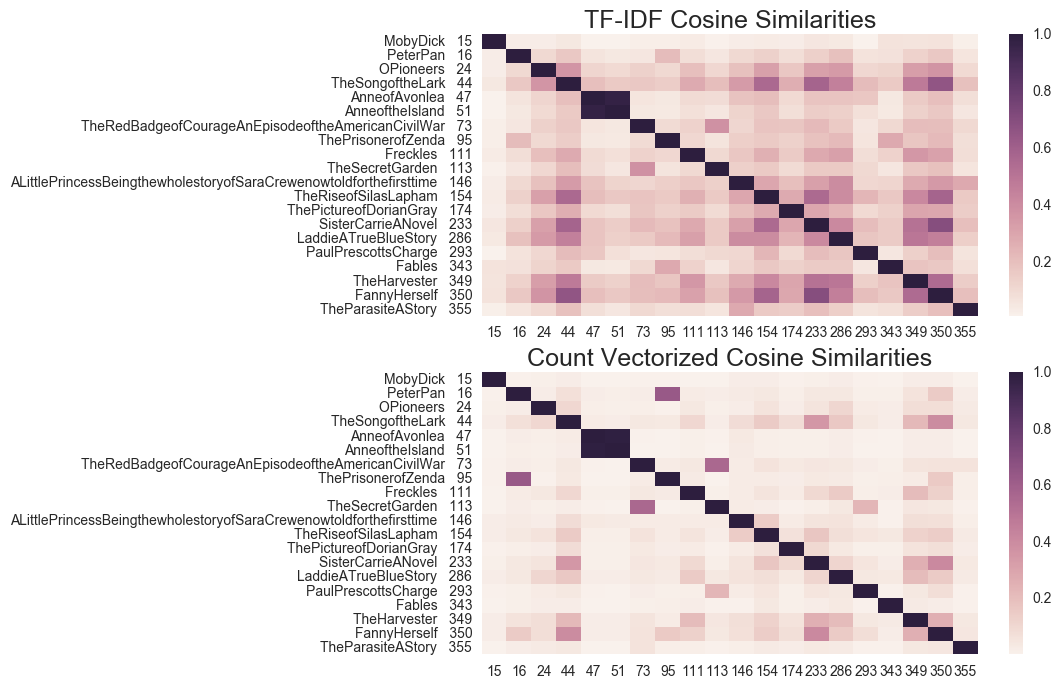

In [45]:
t_subset_similarity = cosine_similarity(tvec_subset)
c_subset_similarity = cosine_similarity(cvec_subset)
s_similarities = []
for book1 in range(20):
    book1_sims = []
    for book2 in range(20):
        book1_sims.append(jaccard(flesch_k_subset.ix[book1,'subjects3'].tolist(), 
                                                flesch_k_subset.ix[book2,'subjects3'].tolist()))
    s_similarities.append(book1_sims)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8))

ylabels = [t + '   ' + str(i) for t, i in zip(flesch_k_subset.title_ascii.head(20).values, flesch_k_subset.book_id.head(20).values)]
xlabels = flesch_k_subset.head(20).book_id.values

sns.heatmap(t_subset_similarity[:20,:20], xticklabels=xlabels, yticklabels=ylabels, ax = ax1)
ax1.set_title('TF-IDF Cosine Similarities', fontsize = 18)

sns.heatmap(c_subset_similarity[:20,:20], xticklabels=xlabels, yticklabels=ylabels, ax = ax2)
ax2.set_title('Count Vectorized Cosine Similarities', fontsize = 18)

plt.show()

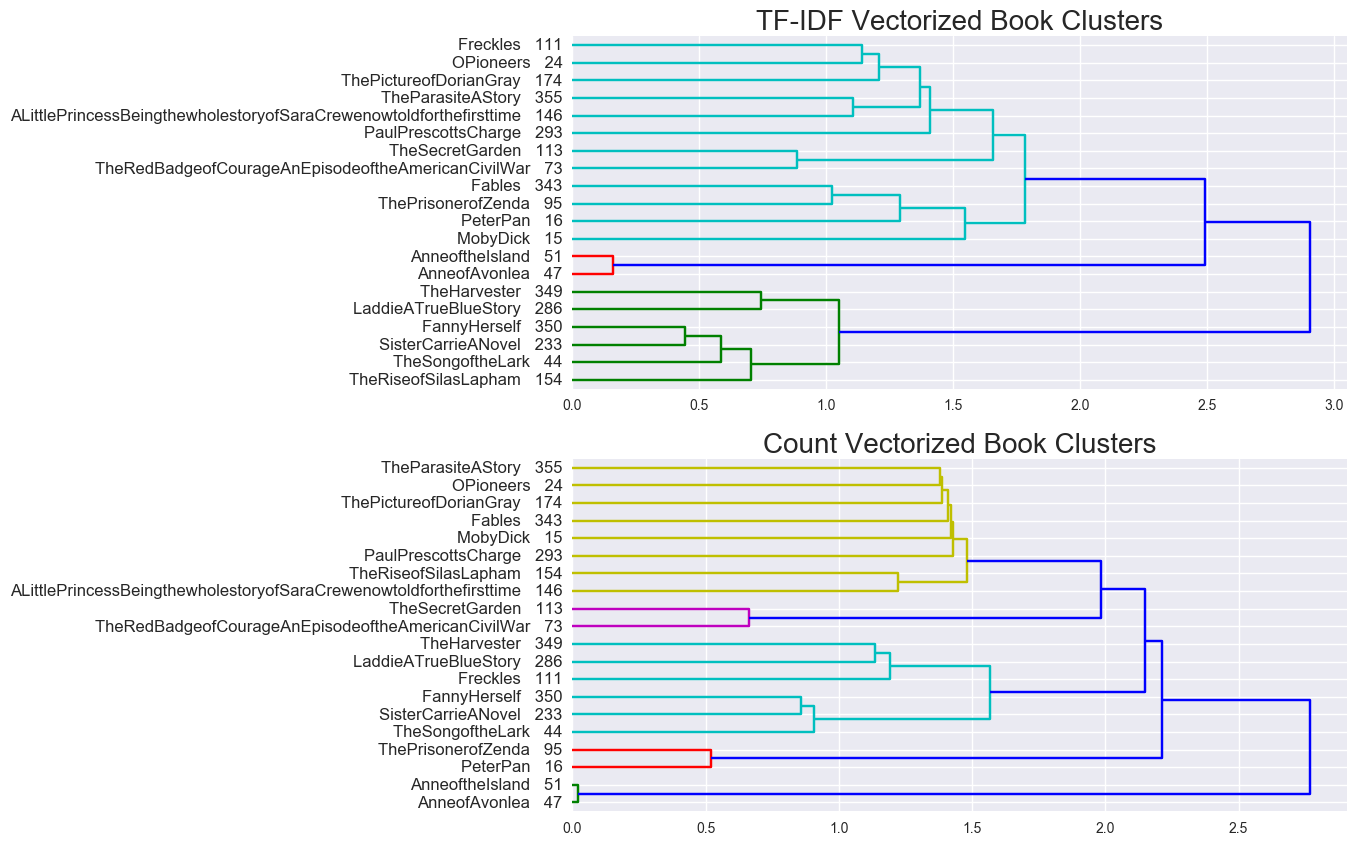

In [46]:
from scipy.cluster.hierarchy import ward, dendrogram
t_linkage_matrix = ward(t_subset_distances[:20,:20])
c_linkage_matrix = ward(c_subset_distances[:20,:20])
names = ylabels

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
dendrogram(t_linkage_matrix, labels = np.array(names), orientation="right", ax=ax1)
ax1.set_title('TF-IDF Vectorized Book Clusters', fontsize = 20)
dendrogram(c_linkage_matrix, labels = np.array(names), orientation="right", ax=ax2)
ax2.set_title('Count Vectorized Book Clusters', fontsize = 20)

plt.show()  

In [47]:
zenda = top_c.ix[2, :]
zenda_cvec = cvec_all[cvec_all['book_id'] == zenda.book_id]
zenda_cvec

,00,000,10,100,101,103,104,105,106,109,...,youâ,zeal,zealous,zealously,zenith,zero,zest,zigzag,zip,zone
40,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0


In [48]:
peter_sterling = top_t.ix[2, :]
peter_sterling_tvec = tvec_all[tvec_all['book_id'] == peter_sterling.book_id]

In [49]:
pan_tvec = tvec_all[tvec_all['book_id'] == chosen_id]
pan_cvec = cvec_all[cvec_all['book_id'] == chosen_id]

In [53]:
zenda_cvec.drop('book_id', axis = 1).T.sort_values(40, ascending = False).head(20).rename(columns = {40: 'Zenda'}).T

,michael,sire,marshal,madame,ay,von,tonight,revolver,chateau,jacob,leapt,highness,countess,moustache,ambassador,robert,learnt,leant,chink,boar
Zenda,180.0,40.0,36.0,34.0,26.0,26.0,23.0,21.0,21.0,19.0,17.0,17.0,12.0,11.0,9.0,9.0,9.0,8.0,8.0,7.0


In [55]:
pan_cvec

,00,000,10,100,101,103,104,105,106,109,...,youâ,zeal,zealous,zealously,zenith,zero,zest,zigzag,zip,zone
1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0


In [56]:
pan_cvec.drop('book_id', axis = 1).T.sort_values(1, ascending = False).head(20).rename(columns = {1: 'Peter Pan'}).T

,michael,pirates,nursery,pirate,ay,jane,fairies,curly,kennel,twins,lily,twin,plank,tick,hullo,claw,frightfully,cleaning,crow,leapt
Peter Pan,109.0,57.0,39.0,35.0,32.0,28.0,24.0,22.0,19.0,14.0,13.0,13.0,12.0,12.0,11.0,11.0,10.0,9.0,9.0,8.0


In [58]:
peter_sterling_tvec.drop('book_id', axis = 1).T.sort_values(7061, ascending = False).head(20).rename(columns = {7061: 'Peter Sterling'}).T

,peter,mr,miss,ll,pierce,ve,mrs,politics,ward,york,oh,convention,didn,till,merely,girl,laughed,woman,isn,dinner
Peter Sterling,0.950499,0.099794,0.091414,0.080862,0.077477,0.065874,0.046726,0.042103,0.041667,0.039734,0.03648,0.034978,0.034841,0.03047,0.029528,0.02915,0.028308,0.027913,0.027485,0.025827


In [60]:
pan_tvec.drop('book_id', axis = 1).T.sort_values(1, ascending = False).head(20).rename(columns = {1: 'Peter Pan'}).T

,peter,hook,michael,darling,john,pirates,boys,mrs,nursery,don,slightly,ay,jane,fairies,island,mr,pan,ship,chapter,captain
Peter Pan,0.781094,0.299442,0.280658,0.190525,0.174765,0.145822,0.112472,0.090757,0.083858,0.069317,0.066853,0.063505,0.062492,0.05898,0.049706,0.049389,0.048352,0.041148,0.040894,0.040798
